# Introduction

This notebook delves into the analysis of a specific dataset sourced from Kaggle, aimed at predicting the likelihood of individuals experiencing late payments on their loans. As a quintessential data science problem, we'll employ methodologies tailored to such analyses.

The dataset comprises various tables, with the train and test tables being our primary focus due to their similarity. Consequently, our analysis will be centered on the train table to ensure applicability to the test data.

We'll leverage Kaggle's platform to seamlessly access and load the dataset for analysis.

This notebook adopts a comprehensive approach to documenting the data science problem, adhering to the CRISP-DM methodology:

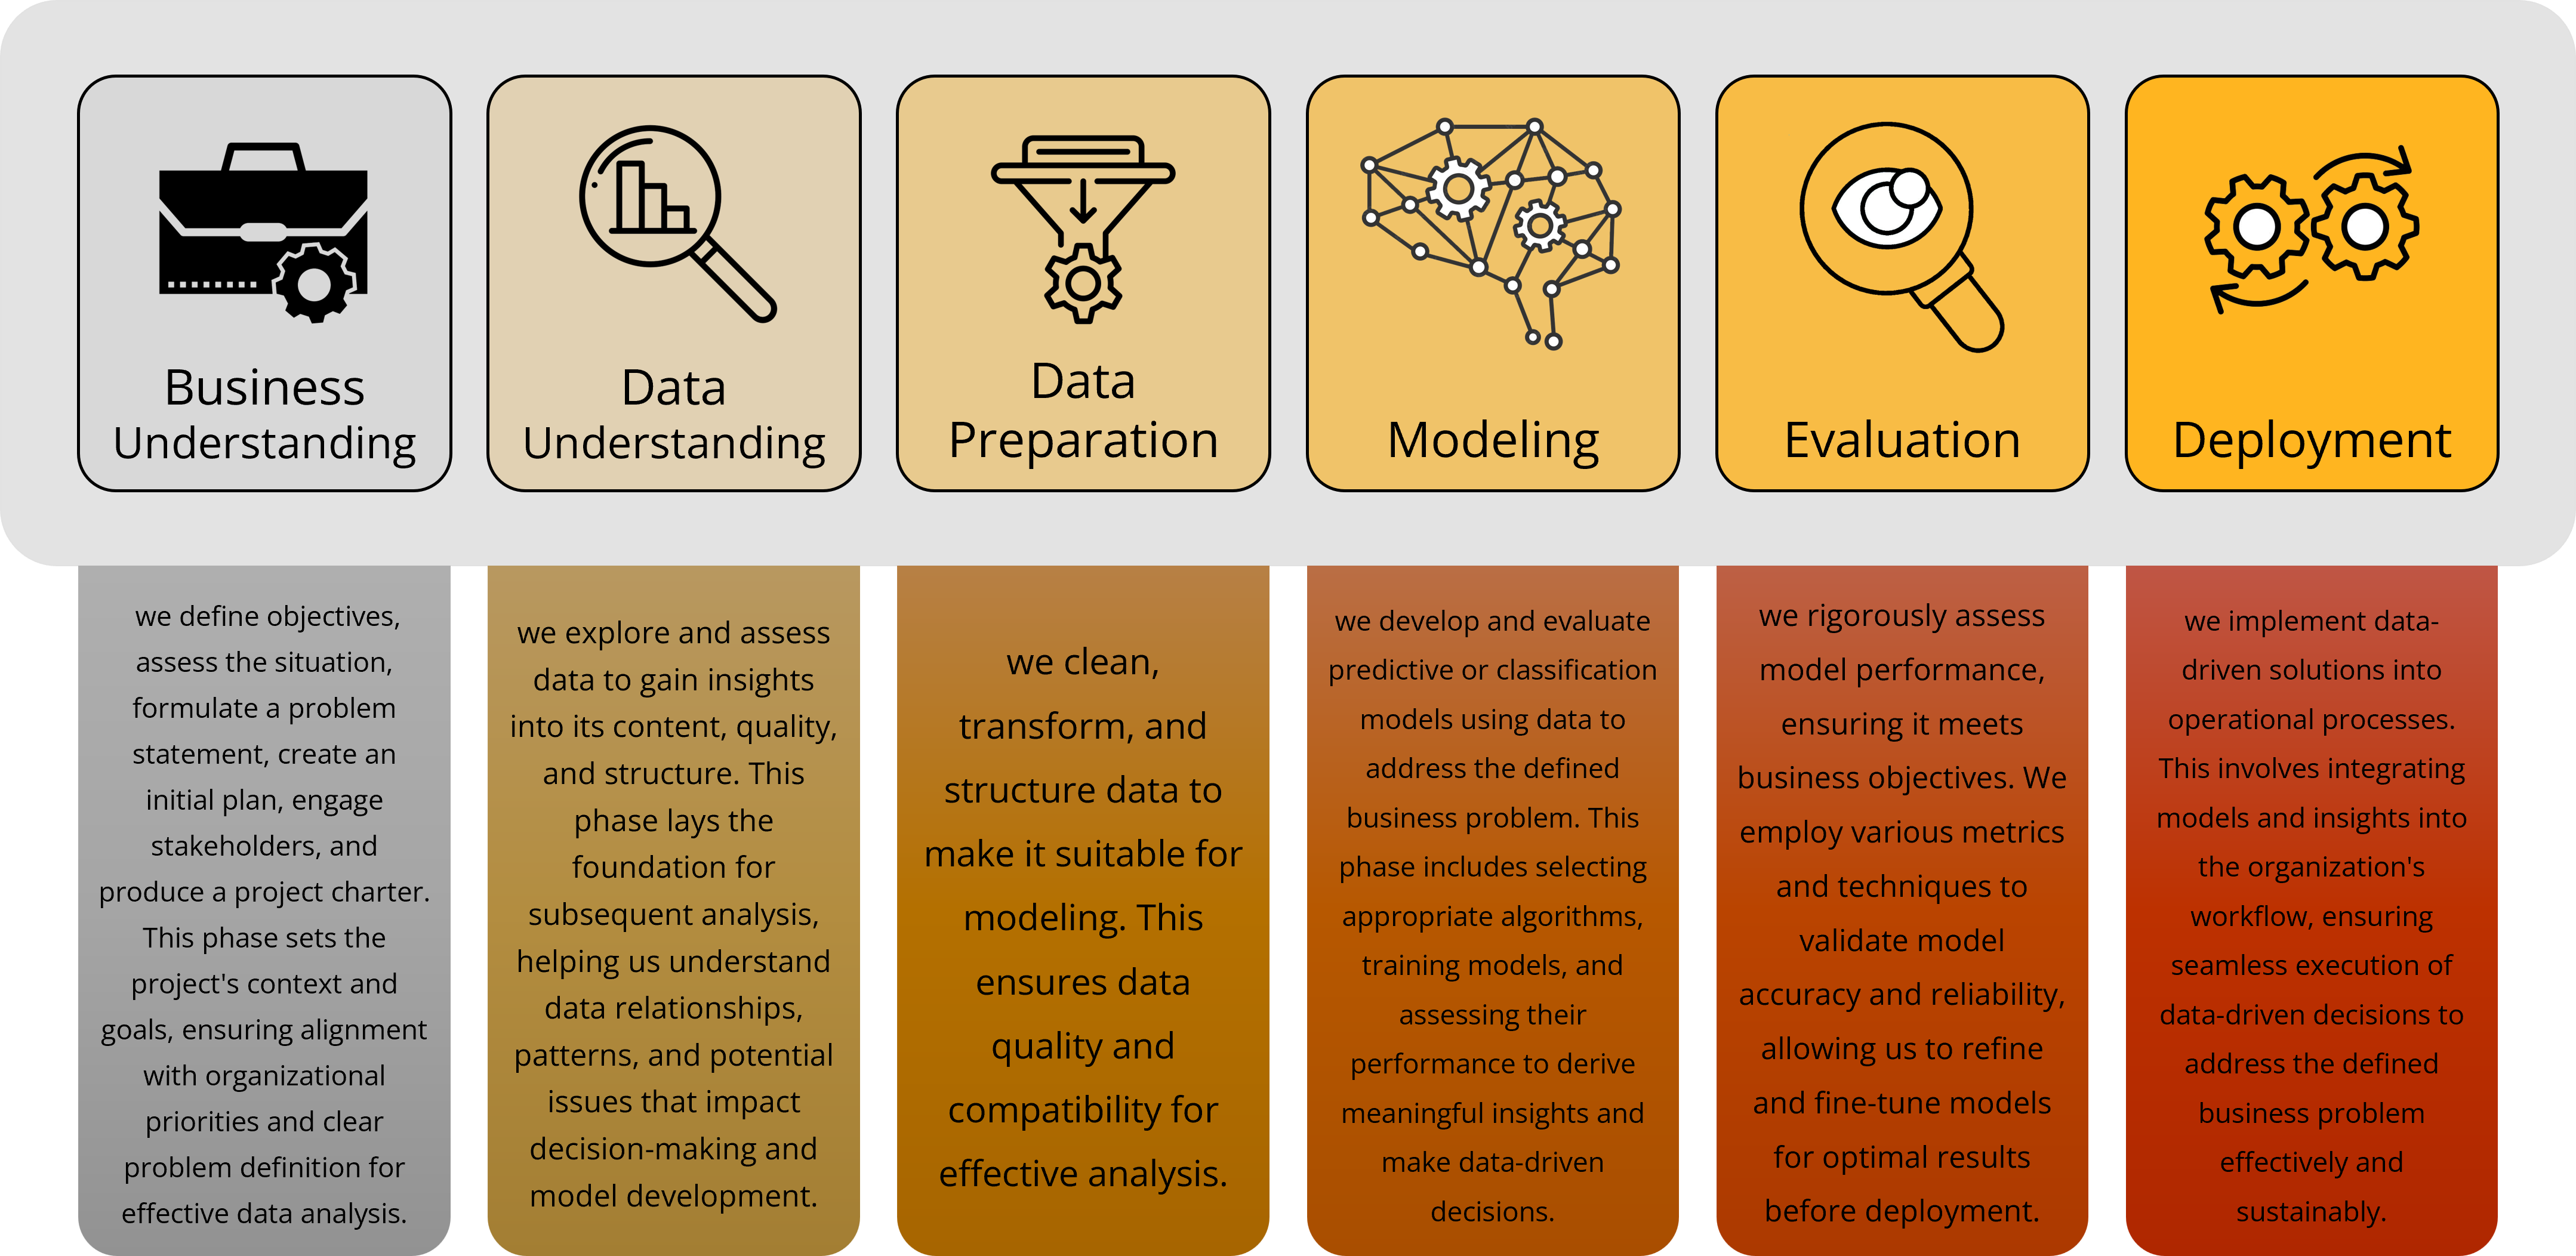

In essence, this methodology comprises the following steps:

1. **Business Understanding**
2. **Data Understanding**
3. **Data Preparation**
4. **Modeling**
5. **Evaluation**
6. **Deployment**

Each step will be thoroughly explained within the notebook.

# 1.Business Understanding

This dataset belongs to micro finance industry. This industry is a subset of fintech industry and has enabled persons and businesses to take small loans.

Microfinance is a specialized financial sector mainly dedicated to providing small-scale loans, facilitating savings, and delivering essential financial services to individuals and small businesses that typically lack access to conventional banking institutions and systems. This field operates with a unique set of challenges and opportunities in it. Users in this sector often show some special financial behaviors compared to mainstream banking clients. They tend to have irregular income streams, limited collateral, and a higher sensitivity to interest rates and fees.

Understanding the behavior of users in the microfinance domain is essential for data-driven decision-making. It involves analyzing how clients interact with financial products, manage their loans and payments, and utilize savings mechanisms. Additionally, it involves studying the impact of microfinance on the financial stability and livelihoods of users, as well as identifying trends and patterns in repayment behaviors.

By gaining some insights into user behavior, data science can play an important role in enhancing the effectiveness of microfinance institutions and also the predictability of user repayments. Data-driven strategies can shape personalized financial products, risk assessment models, and customer retention strategies, contributing to the industry's mission of fostering financial inclusion and socioeconomic development in underserved communities by trying to allocate proper loans to users based on their behavior.

In [1]:
!pip install pyarrow

In [1]:
import re

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns

# STATS
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# ML
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

from scipy import stats

import warnings

warnings.filterwarnings("ignore")
clear_output()

import os

os.chdir("../")

from src import micro

In [2]:
pd.set_option("display.max_rows", 100)

# 2.Data Understanding

The main table that we use to analyze and train our model, is the train dataframe which consists of 122 columns (features), each describing a criteria which has been used in evaluating the customers.

In [3]:
train_df = micro.read_parquet_file("application_train")
train_cols = train_df.columns
print(train_df.info(show_counts=True))
display(train_df.head(5))

# AMT_INCOME_TOTAL = Income of the client
# REGION_POPULATION_RELATIVE = Normalized population of region where client lives (higher number means the client lives in more pop...
# DAYS_BIRTH = Client's age in days at the time of application
# DAYS_EMPLOYED = How many days before the application the person started current employment
# DAYS_REGISTRATION = How many days before the application did client change his registration
# DAYS_ID_PUBLISH = How many days before the application did client change the identity document with which he applied f...
# WEEKDAY_APPR_PROCESS_START = On which day of the week did the client apply for the loan
# HOUR_APPR_PROCESS_START = Approximately at what hour did the client apply for the loan
# EXT_SOURCE_1 = Normalized score from external data source
# EXT_SOURCE_2 = Normalized score from external data source
# EXT_SOURCE_3 = Normalized score from external data source

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


At first we need to make sure that the columns which are present in the training dataset are also present in the test data set too. We leave the "TARGET" column to be, and we will keep the common columns between train and test dataset.

In [4]:
test_df = micro.read_parquet_file("application_test")
# Since we have a big DataFrame we need to make sure that we work on the columns that are present in the test DataFrame too.
shared_data_cols = [col for col in train_cols if col in test_df.columns]
# Add the TARGET Column which isn't available in the test DataFrame
shared_data_cols.append("TARGET")
train_df = train_df.loc[:, shared_data_cols]
display(train_df.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to TARGET
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


None

# 3. Data Preparation

Given the potential presence of inaccuracies or missing data within our dataset, it is imperative to undertake a comprehensive data preparation process as an initial step. 

Furthermore, uncovering latent patterns concealed within the dataset holds the promise of enhancing the predictive capabilities of our model. Hence, diligent efforts will be made to identify and leverage such patterns. 

At first, Since some of the types that has been chosen by pandas automatically might take the memory too much we will try and change the type of some columns.

In [5]:
# Decrease the size of data
train_df = micro.ChangeType(train_df, "int64", "int32")
train_df = micro.ChangeType(train_df, "float64", "float32")

### Missing Values

In ordert o deal with missing values we take severla steps to identify and solve the issues related to them.

First, we want to see how many of our columns have more than acceptable missin values.

In [6]:
na_series = train_df.isna().sum()
na_series = na_series[(na_series != 0)]
na_cols = na_series.index
# See the Null values from low to high
display(na_series.sort_values(ascending=True))
#
print("Number of Null columns: {}".format(len(na_series)))

DAYS_LAST_PHONE_CHANGE               1
CNT_FAM_MEMBERS                      2
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
EXT_SOURCE_2                       660
DEF_60_CNT_SOCIAL_CIRCLE          1021
OBS_60_CNT_SOCIAL_CIRCLE          1021
DEF_30_CNT_SOCIAL_CIRCLE          1021
OBS_30_CNT_SOCIAL_CIRCLE          1021
NAME_TYPE_SUITE                   1292
AMT_REQ_CREDIT_BUREAU_MON        41519
AMT_REQ_CREDIT_BUREAU_WEEK       41519
AMT_REQ_CREDIT_BUREAU_DAY        41519
AMT_REQ_CREDIT_BUREAU_HOUR       41519
AMT_REQ_CREDIT_BUREAU_QRT        41519
AMT_REQ_CREDIT_BUREAU_YEAR       41519
EXT_SOURCE_3                     60965
OCCUPATION_TYPE                  96391
EMERGENCYSTATE_MODE             145755
TOTALAREA_MODE                  148431
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BEGINEXPLUATATION_MODE    150007
YEARS_BEGINEXPLUATATION_MEDI    150007
FLOORSMAX_AVG                   153020
FLOORSMAX_MEDI                  153020
FLOORSMAX_MODE           

Number of Null columns: 67


We have 66 Variables that have missing values. So we need to take care of them before doing any further analysis.


In [7]:
# Create a mask to see Which columns has less than 30% NA Values
nonan_cols = (train_df.isna().sum(axis=0) / train_df.shape[0] * 100) <= 30
display(train_df.loc[:, nonan_cols])

# Select those columns which have more than 30% NA value
nan_cols = nonan_cols[(nonan_cols == False)].index.to_list()
print(
    f"Number of columns with more than acceptable missing values are {len(nan_cols)} and the names of these columns are: {nan_cols}"
)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
307507,456252,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
307508,456253,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0
307509,456254,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1


Number of columns with more than acceptable missing values are 50 and the names of these columns are: ['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', '

We can see that we have more than 50 columns out of 121 which has more than 30% missing values.  But we maybe able to fill them if start to see some pattern in the data or find some other information that could lead us to fill in the values.

At first look, we can see that many of the missing clumns name are related to the porperties of the applicant's house. These Columns name include:

['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

The Median, Average of Mode of the applicant's house has many missing values. we might be able to deal with these values later based on other provided details. First, we start by __Exploratory Data Analysis__ to gain more insights about the data we are trying to analyze.

In [8]:
# Let's find out the names wothoud the AVG or MEDI tags
print(sorted(list(set([x.split("_")[0] for x in nan_cols]))))

['APARTMENTS', 'BASEMENTAREA', 'COMMONAREA', 'ELEVATORS', 'EMERGENCYSTATE', 'ENTRANCES', 'EXT', 'FLOORSMAX', 'FLOORSMIN', 'FONDKAPREMONT', 'HOUSETYPE', 'LANDAREA', 'LIVINGAPARTMENTS', 'LIVINGAREA', 'NONLIVINGAPARTMENTS', 'NONLIVINGAREA', 'OCCUPATION', 'OWN', 'TOTALAREA', 'WALLSMATERIAL', 'YEARS']


These are the explanations for each of the items listed above:

- `APARTMENTS_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `BASEMENTAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `COMMONAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `ELEVATORS_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `ENTRANCES_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `FLOORSMAX_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `FLOORSMIN_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `LANDAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `LIVINGAPARTMENTS_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `LIVINGAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `NONLIVINGAPARTMENTS_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `NONLIVINGAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `YEARS_BEGINEXPLUATATION_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `YEARS_BUILD_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `OWN_CAR_AGE`: Age of client's car
- `OCCUPATION_TYPE`: What kind of occupation does the client have


By Seperating the columns related to house, we could derive a Score-Based system In order to solve the many Na values in the housse descriptions. We observe that all of the Points for the selected house properties are between 0 and 1, so we could derive a Score-based systme just by adding the numbers for each applicant. 
In this way we get a better Score for applicant with better condition in their house and 0 for the aplicant which hasn't provided any house related information.

In [9]:
house_cols = [
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "TOTALAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
]
# Derive the Score for the house
train_df.loc[:, "HOUSE_SCORE"] = train_df.loc[:, house_cols].sum(axis=1)
train_df = train_df.drop(columns=house_cols)

By analyzing the Car related columns we find out that the Na values which are present in "OWN_CAR_AGE" are 99.998% related to those who deosn't have a car. So we can try and fill the empty cells with a value that could describe not having a car or it could seperate the people who has a car from who doesn't.

Maybe the -1 value could be a good start.

In [10]:
tmp_df = train_df[["FLAG_OWN_CAR", "OWN_CAR_AGE"]]
car_na_df = tmp_df[(tmp_df["OWN_CAR_AGE"].isna())]
print(car_na_df["FLAG_OWN_CAR"].describe())

n_values = car_na_df[(car_na_df["FLAG_OWN_CAR"] == "N")]
n_percentage_value = len(n_values) / len(car_na_df) * 100
print(
    "percent of N values related to NA 'OWN_CAR_AGE' values: {:.3f}%".format(
        n_percentage_value
    )
)

count     202929
unique         2
top            N
freq      202924
Name: FLAG_OWN_CAR, dtype: object
percent of N values related to NA 'OWN_CAR_AGE' values: 99.998%


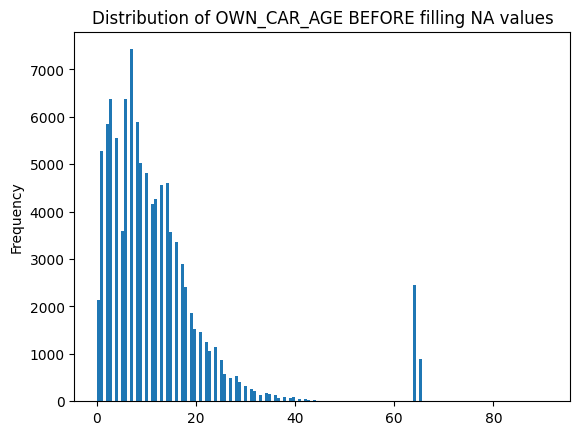

In [11]:
micro.plot_car_histogram(train_df, "BEFORE")

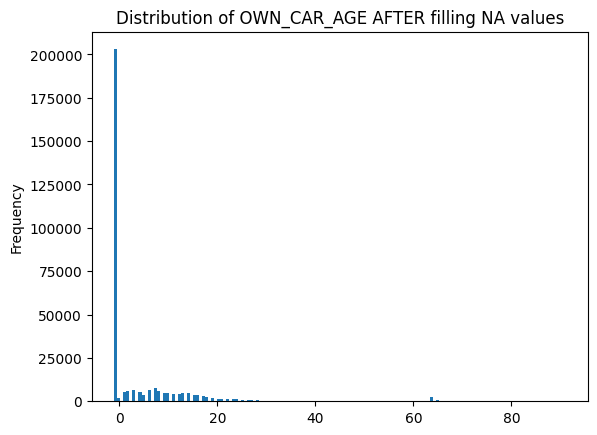

In [12]:
train_df["OWN_CAR_AGE"] = train_df["OWN_CAR_AGE"].fillna(-1)
micro.plot_car_histogram(train_df, "AFTER")

Though it seems that we have altered the Original distribution of the OWN_CAR_AGE, but we just added a distinct value which could identify that we don't have a car and the distribution of the rest of the data is unchanged.

let's check again to see about the NA values of the columns.

In [13]:
high_na_cols = (train_df.isna().sum(axis=0) / train_df.shape[0] * 100) >= 30
display(train_df.loc[:, high_na_cols])

,OCCUPATION_TYPE,EXT_SOURCE_1,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Laborers,0.083037,reg oper account,block of flats,"Stone, brick",No
1,Core staff,0.311267,reg oper account,block of flats,Block,No
2,Laborers,NaN,None,None,None,None
3,Laborers,NaN,None,None,None,None
4,Core staff,NaN,None,None,None,None
...,...,...,...,...,...,...
307506,Sales staff,0.145570,reg oper account,block of flats,"Stone, brick",No
307507,None,NaN,reg oper account,block of flats,"Stone, brick",No
307508,Managers,0.744026,reg oper account,block of flats,Panel,No
307509,Laborers,NaN,None,block of flats,"Stone, brick",No


We were able to decrease the number high NA columns to 6. Now we need to figure out a sense between the columns to see if there is a way to find the missing values.

Also we shoudn't forget columns that have low NA values, they still need to be taken care of.

In [14]:
na_percent_values = train_df.isna().sum(axis=0) / train_df.shape[0] * 100
low_na_cols = (na_percent_values <= 30) & (na_percent_values > 0)
display(train_df.loc[:, low_na_cols].head(5))
print(train_df.loc[:, low_na_cols].isna().sum(axis=0) / len(train_df) * 100)

,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,24700.5,351000.0,Unaccompanied,1.0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,35698.5,1129500.0,Family,2.0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6750.0,135000.0,Unaccompanied,1.0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29686.5,297000.0,Unaccompanied,2.0,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21865.5,513000.0,Unaccompanied,1.0,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


AMT_ANNUITY                    0.003902
AMT_GOODS_PRICE                0.090403
NAME_TYPE_SUITE                0.420148
CNT_FAM_MEMBERS                0.000650
EXT_SOURCE_2                   0.214626
EXT_SOURCE_3                  19.825307
OBS_30_CNT_SOCIAL_CIRCLE       0.332021
DEF_30_CNT_SOCIAL_CIRCLE       0.332021
OBS_60_CNT_SOCIAL_CIRCLE       0.332021
DEF_60_CNT_SOCIAL_CIRCLE       0.332021
DAYS_LAST_PHONE_CHANGE         0.000325
AMT_REQ_CREDIT_BUREAU_HOUR    13.501631
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
dtype: float64


We can see that many of the NA columns has less than 1% NA values in them so they can be dropped. but the columns ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_19'] has a relatively high NA values. We also should find a way to take care of these values.

For now we don't drop them, Wemight be able to recover some data using EDA and finding the relationship between columns.

<div style="text-align:center">
    <h1>Exploratory Data Analysis</h1>
</div>


<div style="text-align:center;">
    <img src="../assets/img/Exploratory_data_anaysis.jpg" alt="EDA" style="width: 800px;"/>
</div>



</br>
exploratory data analysis (EDA) serves as the foundational phase of any analytical project. During EDA, we analyze the dataset to gain valuable insights and find underlying patterns. This involves employing statistical methods, visualizations, and data manipulation techniques to uncover trends, anomalies, and relationships within the data.

Since some of the behaviors are not vivid we need to use different visuals or methods to find these patterns. (At the end we might not even find any!)

## TARGET

First, We see the distribution of our target variable.

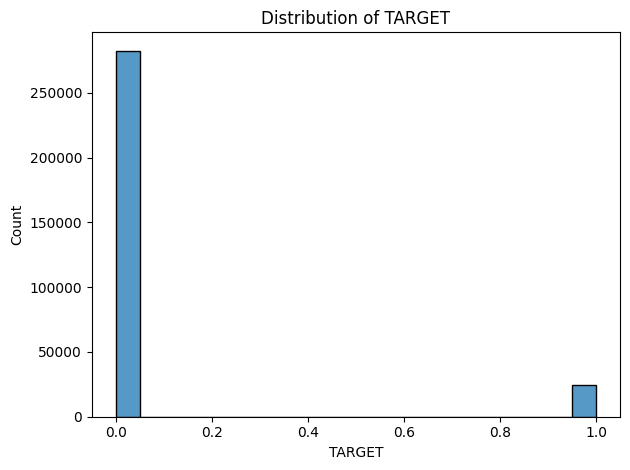

In [15]:
sns.histplot(train_df["TARGET"]).set(title="Distribution of TARGET")
plt.tight_layout()
plt.show()

## Correlation

Since our data has values with different data types We start by grouping the columns that have numerical type with each other.

For numerical Values we need to find the values that has high correlation with each other so that we could reduce the size of the data. So we can find the name of the columns which has high correlation with each other as below and save to a DataFrame:

In [16]:
micro.compute_entire_correlation(df=train_df, threshold=0.7)

Numerical columns are: 
 ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUME

The final Variables which has higher than threshold correlation are as table below: 
                             0                            1                2
0                CNT_CHILDREN              CNT_FAM_MEMBERS             None
1                  AMT_CREDIT                  AMT_ANNUITY  AMT_GOODS_PRICE
2                 AMT_ANNUITY              AMT_GOODS_PRICE             None
3        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY             None
4  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION             None
5      REG_CITY_NOT_WORK_CITY      LIVE_CITY_NOT_WORK_CITY             None
6    OBS_30_CNT_SOCIAL_CIRCLE     OBS_60_CNT_SOCIAL_CIRCLE             None
7    DEF_30_CNT_SOCIAL_CIRCLE     DEF_60_CNT_SOCIAL_CIRCLE             None


Based on the above Table we can deduce some results about our dataset and we might be able to reduce the size.

Description of the variables:
- `CNT_CHILDREN`: How many children does client have
- `CNT_FAM_MEMBERS`: How many family members does client have
- `AMT_CREDIT`: Credit amount of the loan
- `AMT_ANNUITY`: Loan annuity
- `AMT_GOODS_PRICE`: For consumer loans it is the price of the goods for which the loan is given
- `REGION_RATING_CLIENT`: Our rating of the region where client lives (1,2,3)
- `REGION_RATING_CLIENT_W_CITY`: Our rating of the region where client lives with taking city into account (1,2,3)
- `OBS_30_CNT_SOCIAL_CIRCLE`: How many observation of client's social surroundings with observable 30 DPD (days past due) default
- `OBS_60_CNT_SOCIAL_CIRCLE`: How many observation of client's social surroundings with observable 60 DPD (days past due) default
- `DEF_30_CNT_SOCIAL_CIRCLE`: How many observation of client's social surroundings defaulted on 30 DPD (days past due) 
- `DEF_60_CNT_SOCIAL_CIRCLE` How many observation of client's social surroundings defaulted on 60 DPD (days past due) 

Analyzing the output of the correlation table:
- It is obvious that `CNT_CHILDREN` is strictly related to `CNT_FAM_MEMBERS`
- `AMT_CREDIT`, `AMT_AANUITY` and `AMT_GOODS_PRICE` are highly related which is also obvious since the credit that a person is searching for is mostly related to the price of the good that they are trying to buy.


Let's see the relationship between columns in a diagram:

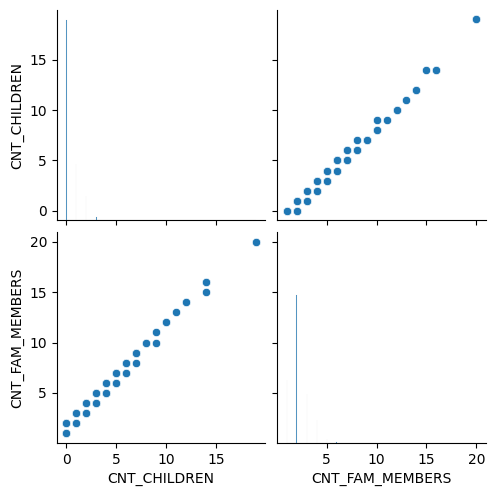

Correlation between 2 variables: 
                  CNT_CHILDREN  CNT_FAM_MEMBERS
CNT_CHILDREN         1.000000         0.879161
CNT_FAM_MEMBERS      0.879161         1.000000


In [17]:
micro.compute_corr_hist_plot(train_df, ["CNT_CHILDREN", "CNT_FAM_MEMBERS"])

Total Family members is always a function of the number of children and will have a high correlation, we will try and subtract the number of children from Family Members and name it "CNT_OTHER_FAM_MEMEBRS" This way we have erased the link between two variables.

In [18]:
train_df["CNT_OTHER_FAM_MEMBERS"] = (
    train_df["CNT_FAM_MEMBERS"] - train_df["CNT_CHILDREN"]
)
(train_df[["CNT_OTHER_FAM_MEMBERS", "CNT_CHILDREN"]].corr())

,CNT_OTHER_FAM_MEMBERS,CNT_CHILDREN
CNT_OTHER_FAM_MEMBERS,1.00000,0.17803
CNT_CHILDREN,0.17803,1.00000


The low computed correlation approves that our method have works, we have kept the important data and also removed the correlation ebtween two varianbles.

Next we take a look at Credit variables:

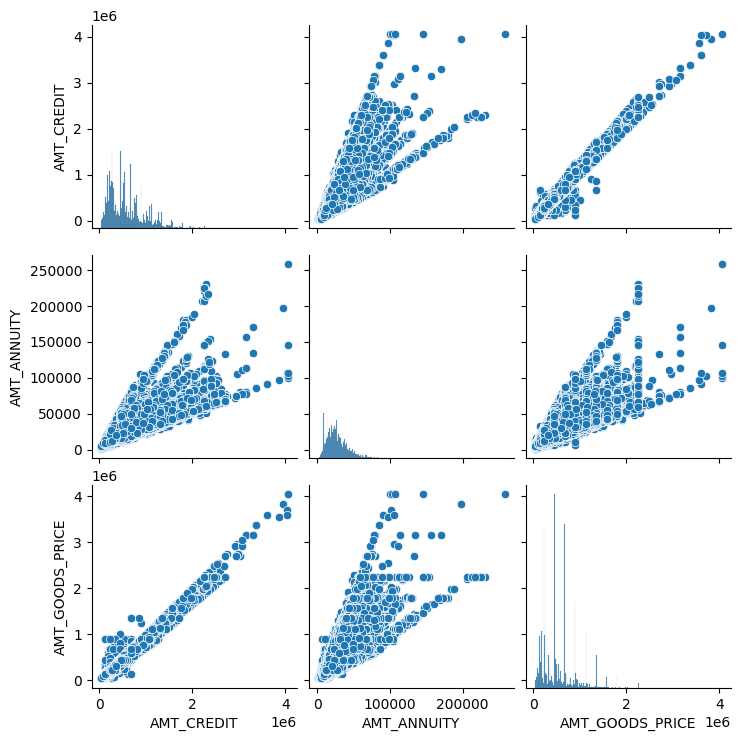

Correlation between 3 variables: 
                  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE
AMT_CREDIT         1.000000     0.770138         0.986968
AMT_ANNUITY        0.770138     1.000000         0.775109
AMT_GOODS_PRICE    0.986968     0.775109         1.000000


In [19]:
micro.compute_corr_hist_plot(train_df, ["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"])

The correlation between `AMT_CREDIT` and `AMT_GOODS_PRICE` is very high (98.7%) We could replace thse two values by the division of `AMT_GOOD_PRICE/AMT_CREDIT`. This new variable could summarize that how much of the GOODs price the client has recieved the credit. Let's check our hypothesis:

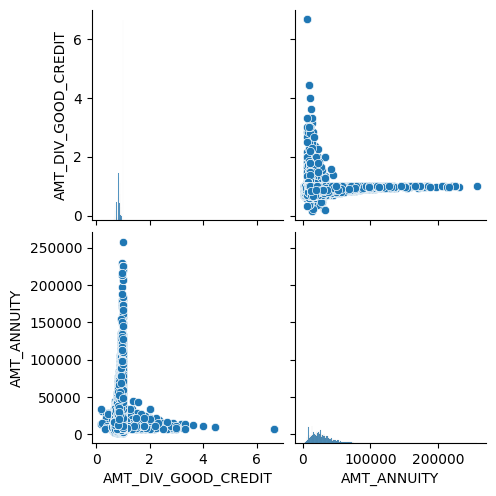

Correlation between 2 variables: 
                      AMT_DIV_GOOD_CREDIT  AMT_ANNUITY
AMT_DIV_GOOD_CREDIT              1.00000      0.03376
AMT_ANNUITY                      0.03376      1.00000


In [20]:
train_df["AMT_DIV_GOOD_CREDIT"] = train_df["AMT_GOODS_PRICE"] / train_df["AMT_CREDIT"]
micro.compute_corr_hist_plot(train_df, ["AMT_DIV_GOOD_CREDIT", "AMT_ANNUITY"])

We have been able to remove the high correlation between amount of credit variables.

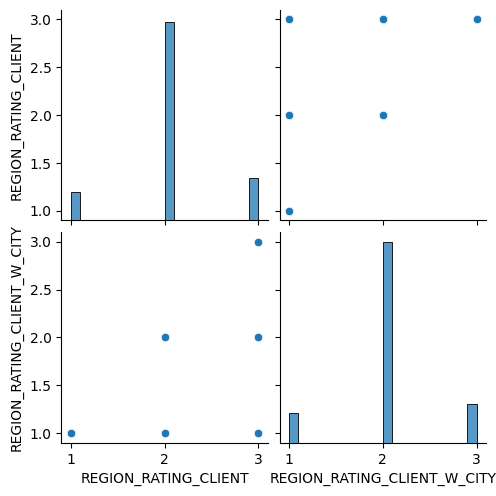

Correlation between 2 variables: 
                              REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY
REGION_RATING_CLIENT                     1.000000                     0.950842
REGION_RATING_CLIENT_W_CITY              0.950842                     1.000000


In [21]:
micro.compute_corr_hist_plot(
    train_df, ["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"]
)

With a high value of 95% correlation, we might be able to merge these two variables. We define a varibale `EFF_CITY_ON_REGION` which values the effect of city on changing the region's score and we drop the `REGION_RATING_CLIENT_W_CITY` column.

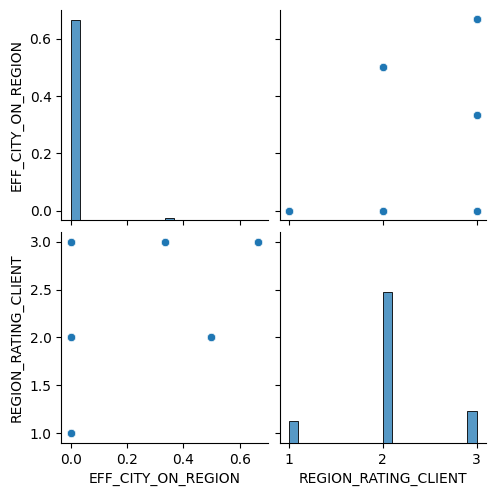

Correlation between 2 variables: 
                       EFF_CITY_ON_REGION  REGION_RATING_CLIENT
EFF_CITY_ON_REGION              1.000000              0.177289
REGION_RATING_CLIENT            0.177289              1.000000


In [22]:
# Effect of city on the region's score
train_df["EFF_CITY_ON_REGION"] = (
    1 - train_df["REGION_RATING_CLIENT_W_CITY"] / train_df["REGION_RATING_CLIENT"]
)

micro.compute_corr_hist_plot(train_df, ["EFF_CITY_ON_REGION", "REGION_RATING_CLIENT"])

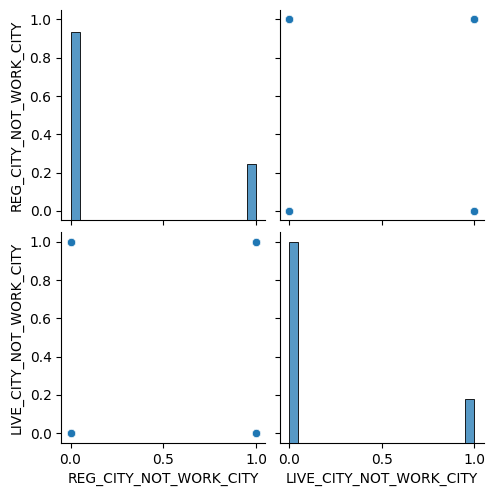

Correlation between 2 variables: 
                          REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY
REG_CITY_NOT_WORK_CITY                 1.000000                 0.825575
LIVE_CITY_NOT_WORK_CITY                0.825575                 1.000000


In [23]:
micro.compute_corr_hist_plot(
    train_df, ["REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"]
)

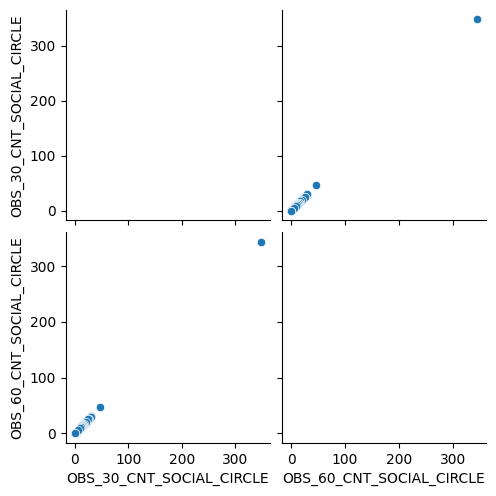

Correlation between 2 variables: 
                           OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE
OBS_30_CNT_SOCIAL_CIRCLE                   1.00000                   0.99849
OBS_60_CNT_SOCIAL_CIRCLE                   0.99849                   1.00000


In [24]:
micro.compute_corr_hist_plot(
    train_df, ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE"]
)

As we can see the correlation between these two variables are very high as they could even one variable. So we take the Maximum between them and change the name to more general one like `OBS_CNT_SOCIAL_CIRCLE`

In [25]:
train_df["OBS_CNT_SOCIAL_CIRCLE"] = train_df[
    ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE"]
].max(axis=1)

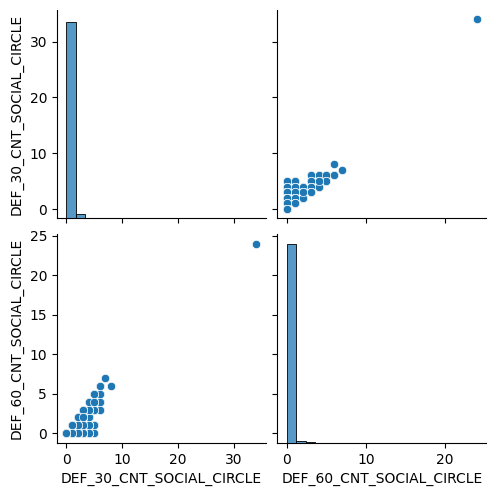

Correlation between 2 variables: 
                           DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE                  1.000000                  0.860517
DEF_60_CNT_SOCIAL_CIRCLE                  0.860517                  1.000000


In [26]:
micro.compute_corr_hist_plot(
    train_df, ["DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
)

Correlation between two variables are 86% which is also considered high. The definition of both variables is the number of defaulted persons in the social circle, The only thing that is different between these two si the number DPD (Days Past Due). We could try and remove the shared values in 30 and 60 DPD and define a new variable which is the number of people with more than 30 DPD.

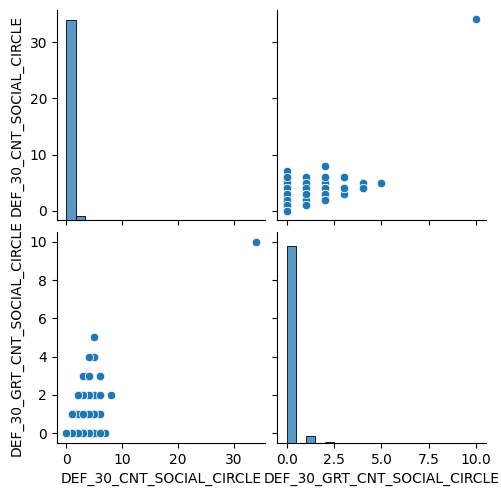

Correlation between 2 variables: 
                               DEF_30_CNT_SOCIAL_CIRCLE  \
DEF_30_CNT_SOCIAL_CIRCLE                      1.000000   
DEF_30_GRT_CNT_SOCIAL_CIRCLE                  0.590219   

                              DEF_30_GRT_CNT_SOCIAL_CIRCLE  
DEF_30_CNT_SOCIAL_CIRCLE                          0.590219  
DEF_30_GRT_CNT_SOCIAL_CIRCLE                      1.000000  


In [27]:
train_df["DEF_30_GRT_CNT_SOCIAL_CIRCLE"] = (
    train_df["DEF_30_CNT_SOCIAL_CIRCLE"] - train_df["DEF_60_CNT_SOCIAL_CIRCLE"]
)

micro.compute_corr_hist_plot(
    train_df, ["DEF_30_CNT_SOCIAL_CIRCLE", "DEF_30_GRT_CNT_SOCIAL_CIRCLE"]
)

We were able to decrease the correlation value to about 60% with this approach.

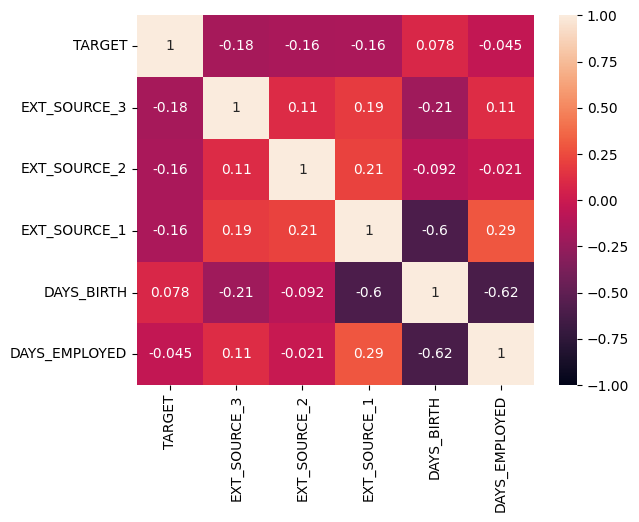

In [28]:
corr_df = train_df[
    [
        "TARGET",
        "EXT_SOURCE_3",
        "EXT_SOURCE_2",
        "EXT_SOURCE_1",
        "DAYS_BIRTH",
        "DAYS_EMPLOYED",
    ]
].corr()
sns.heatmap(corr_df, vmin=-1.0, vmax=1.0, annot=True)
plt.show()

## Outliers

After dealing with high correlation columns, We could check other variables that could have some information or might be related to the previously analyzed variables.

We start by `AMT_INCOME_TOTAL` Column which is related to other `AMT` columns.

- `AMT_INCOME_TOTAL`: Income of the client

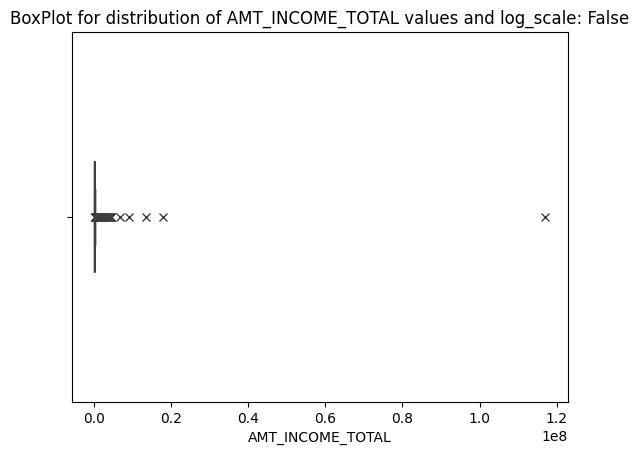

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


In [29]:
micro.plot_box_var(train_df, "AMT_INCOME_TOTAL", log_scale=False)

print(train_df["AMT_INCOME_TOTAL"].describe())

It seems that our data has some values that which are extreme. Let's plot the boxplot with log scale.

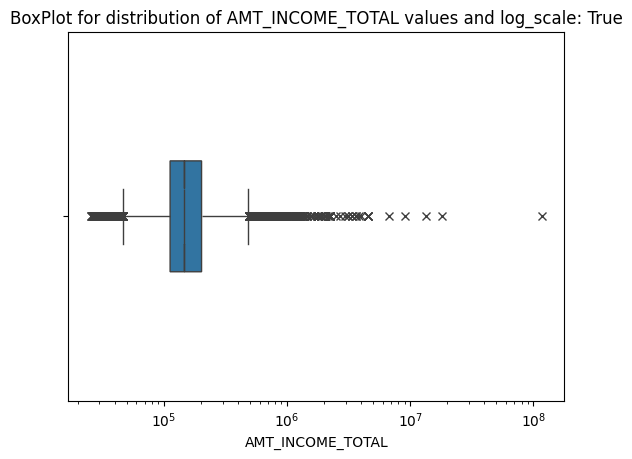

In [30]:
micro.plot_box_var(train_df, "AMT_INCOME_TOTAL", log_scale=True)

Let's see if we can have a distribution about the outliers data and see how we can handle them, First we try and use the `log` transform to see if the distribution of data is close to normal distribution.

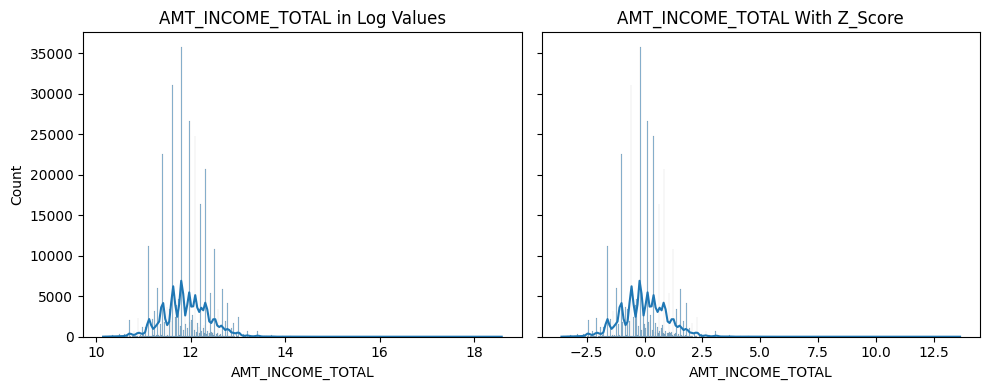

In [31]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10, 4))
sns.histplot(np.log(train_df["AMT_INCOME_TOTAL"]), kde=True, ax=ax[0]).set(
    title="AMT_INCOME_TOTAL in Log Values"
)


sns.histplot(
    stats.zscore(np.log(train_df["AMT_INCOME_TOTAL"])), kde=True, ax=ax[1]
).set(title="AMT_INCOME_TOTAL With Z_Score")
fig.tight_layout()
plt.show()

We could use Z-Score outlier detection and replace the outlier values with `mean + 3*sigma` values.

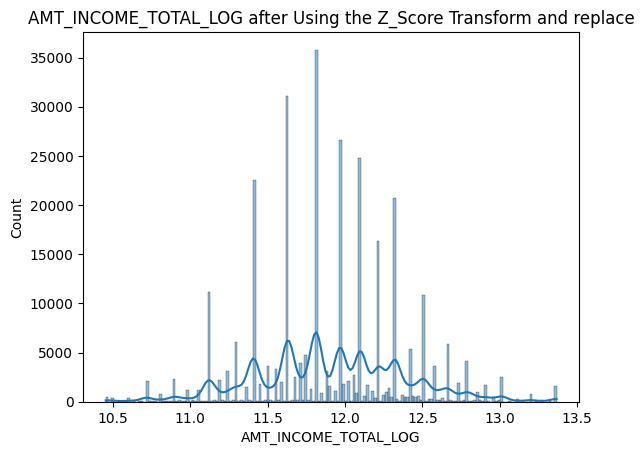

In [32]:
train_df, zscore_lower_thresh, zscore_upper_thresh = micro.compute_transform_zscore(
    data_df=train_df, col_name="AMT_INCOME_TOTAL"
)

sns.histplot(
    train_df["AMT_INCOME_TOTAL_LOG"],
    kde=True,
).set(title="AMT_INCOME_TOTAL_LOG after Using the Z_Score Transform and replace")

fig.tight_layout()
plt.show()

We also double check the correlation with other credit amount varibales:

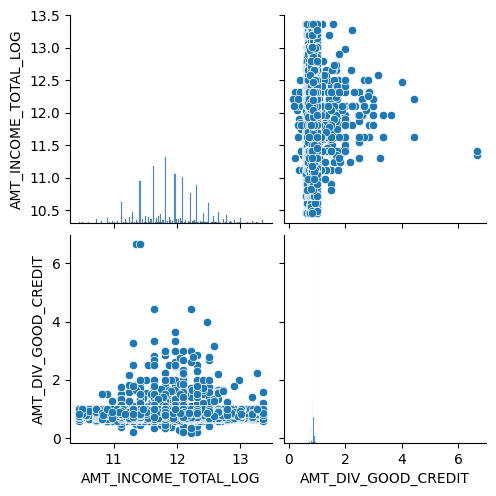

Correlation between 2 variables: 
                       AMT_INCOME_TOTAL_LOG  AMT_DIV_GOOD_CREDIT
AMT_INCOME_TOTAL_LOG              1.000000             0.037449
AMT_DIV_GOOD_CREDIT               0.037449             1.000000


In [33]:
micro.compute_corr_hist_plot(train_df, ["AMT_INCOME_TOTAL_LOG", "AMT_DIV_GOOD_CREDIT"])

Let's Explore some other columns which contain other information about the data. We start by column `DAYS_EMPLOYED`:

- `DAYS_EMPLOYED`: How many days before the application the person started current employment.

Let's first plot the distribution of data:

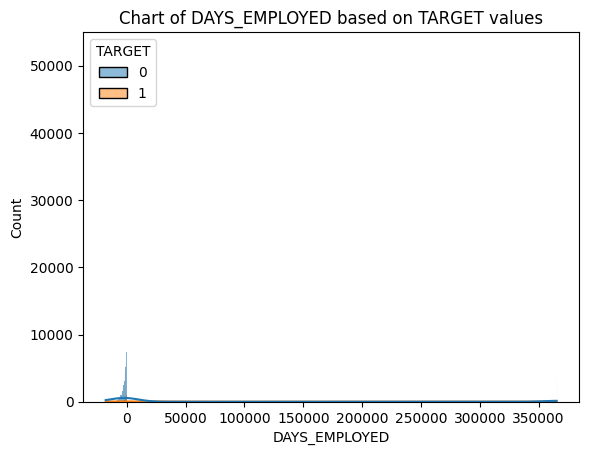

In [34]:
micro.plot_hist_var_target(train_df, "DAYS_EMPLOYED")

It seems that there are some high values which are so much apart from the most of data:

In [35]:
train_df["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

There is a Very high value of 365243 Days (By definition of the varibale BEFORE the application). Based on the values we see in the column the most of the values seem to be negative which based on the definition it makes sense.

So we need to see how many the positive values we have sinc ethey could be a wrong number or NA value which were replace mistakenly.

In [39]:
employ_condition = (train_df["DAYS_EMPLOYED"] > 0)
print(train_df.loc[employ_condition, "DAYS_EMPLOYED"])

print("\nStatistics of Values more than zero: \n", train_df.loc[employ_condition, "DAYS_EMPLOYED"].describe())

8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64

Statistics of Values more than zero: 
 count     55374.0
mean     365243.0
std           0.0
min      365243.0
25%      365243.0
50%      365243.0
75%      365243.0
max      365243.0
Name: DAYS_EMPLOYED, dtype: float64


We see that all of the values more than zero (55374 Counts) are 365243, So we can replace them all with NA values so later we decide for a logical value to fill them.

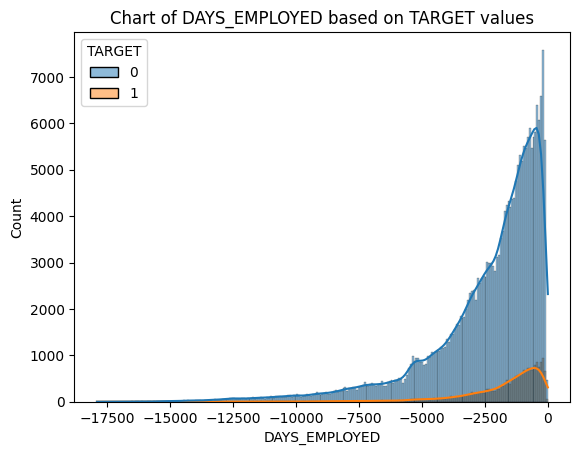

In [40]:
row_condition = (train_df["DAYS_EMPLOYED"]>0)
train_df.loc[row_condition, "DAYS_EMPLOYED"] = np.nan

micro.plot_hist_var_target(train_df, "DAYS_EMPLOYED")

At the end we will drop the unneeded columns:

In [103]:
no_need_cols = [
    "CNT_FAM_MEMBERS",
    "AMT_INCOME_TOTAL",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "REGION_RATING_CLIENT_W_CITY",
    "AMT_CREDIT",
    "AMT_GOODS_PRICE",
]

train_df = train_df.drop(columns=no_need_cols)

<div style="text-align:center">
    <h1>FEATURE ENGINEERING</h1>
</div>


<div style="text-align:center">
    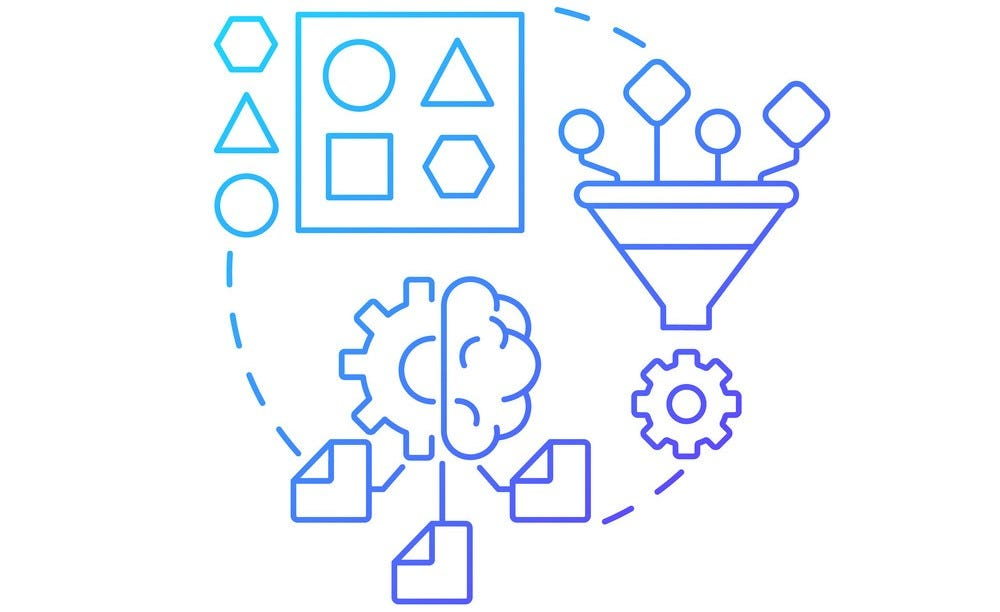
</div>



Feature engineering is a critical component of the data science workflow, encompassing the strategic crafting and transformation of raw data into informative features that enhance the performance of machine learning models. It entails a multifaceted process that involves selecting, transforming, and augmenting features to effectively capture underlying patterns and relationships within the data. Through the manipulation of variables, feature engineering aims to extract meaningful insights, mitigate noise, and improve the predictive power of models.

### TRAIN DataFrame Feature Engineering

In [104]:
def factorize_col(
    df: pd.DataFrame, col_name: str
) -> tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    """Factorize the Categorical columns.

    Args:
        df:
            The DataFrame with categorical data.
        col_name:
            The name of the categorical column.
    Returns:
        The factorized DataFrame, unique values of the factorization, the Pandas Categroical object.
    """
    cat = pd.Categorical(df[col_name])
    factorize_array, factorize_uniques = pd.factorize(cat)
    df[col_name] = factorize_array

    return df, factorize_uniques, cat

In [105]:
def onehot_conv(df: pd.DataFrame, col_name: str) -> tuple[pd.DataFrame, OneHotEncoder]:
    """Convert the specified column with onehot encoder.

    Args:
        df:
            The specified DataFrame with categorical variables.
        col_name:
            The name of the column in DataFrame which has catgeorical values.

    Returns:
        The transformed DataFrame and the object for onehot encoder.
    """
    encoder = OneHotEncoder(handle_unknown="infrequent_if_exist")
    simp_imp = SimpleImputer(strategy="most_frequent")
    array = simp_imp.fit_transform(df[col_name].to_numpy()[..., np.newaxis]).ravel()
    unique_cols = np.unique(array)
    oneh_names = [f"{col_name}_{u}" for u in unique_cols]
    df[oneh_names] = (
        encoder.fit_transform(array.reshape(-1, 1)).toarray().astype(np.int8)
    )

    return df, encoder

If we look carefuly at the training DataFrame we have some columns which starts by thename "FLAG". These columns try to describe each applicant based on having each item which is mentioned in the column name. We can imagine this FLAGs as some points that each applicant might get.

- `FLAG_MOBIL`: Did client provide mobile phone (1=YES, 0=NO)
- `FLAG_EMP_PHONE`: Did client provide work phone (1=YES, 0=NO)
- `FLAG_WORK_PHONE`: Did client provide home phone (1=YES, 0=NO)
- `FLAG_CONT_MOBILE`: Was mobile phone reachable (1=YES, 0=NO)
- `FLAG_PHONE`: Did client provide home phone (1=YES, 0=NO)
- `FLAG_EMAIL`: Did client provide email (1=YES, 0=NO)


So instead of having multiple FLAGs We can add the flags for each customer to derive a point based on the number of flags each applicant has. if an applicant has all the FLAGs their point will be higher.

So we name the new columns as "FLAG_CONTACT" since it describes the overall points that an applicant gets for their provided contact details.

In [106]:
flag_cols = [
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
]
train_df["FLAG_CONTACT"] = train_df[flag_cols].sum(axis=1)
train_df = train_df.drop(columns=flag_cols)

We also have "FLAG_OWN_CAR" and "FLAG_OWN_REALTY" which have different values in them ("Y" and "N") and can't be summed with these values in their original form, so we can replace them. Frist, we check for missing values in these two columns if there is any values missing it is logical to assume the value is "N" which indicates that the applicant doesn't have that item.

- `FLAG_OWN_CAR`: Flag if the client owns a car.
- `FLAG_OWN_REALTY`: Flag if the client owns a House.

Then we can substitue the values in them with numerical values .

In [107]:
# Now we know that we don't have any missing values in these columns
train_df[["FLAG_OWN_CAR", "FLAG_OWN_REALTY"]].isna().sum()

FLAG_OWN_CAR       0
FLAG_OWN_REALTY    0
dtype: int64

In [108]:
# SUbstitute the values fr Y and N
train_df = train_df.pipe(
    micro.substitute_yn_values, col_names=["FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
)

We have columns by the name of FLAG_DCOUMENT_2 to FLAG_DOCUMENT_22 which also describes the applicant's situation and tell us if they have a certain document present in their application or not. So whom ever has all the document could have a higher probability of getting the loan.

- `FLAG_DOCUMENT_i` : Did client provide document i (i is between 2 to 22)

we make a "FLAG_DOCUMENT" column based on the sum of the flags for each 22 document numbers that an applicant has.

In [109]:
flag_cols = [f"FLAG_DOCUMENT_{i}" for i in range(2, 22)]
train_df["FLAG_DOCUMENT"] = train_df[flag_cols].sum(axis=1)
train_df = train_df.drop(columns=flag_cols)

Some of the flags mentioned in the columns could potentially have negative impact on the applicants probability of getting the loan, sow we can use a backward approach in setting the points for these columns. If a person has all the flags should have apoint less than others. 

- `REG_REGION_NOT_LIVE_REGION`: Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)
- `REG_REGION_NOT_WORK_REGION`: Flag if client's permanent address does not match work address (1=different, 0=same, at region level)
- `LIVE_REGION_NOT_WORK_REGION`: Flag if client's contact address does not match work address (1=different, 0=same, at region level)
- `REG_CITY_NOT_LIVE_CITY`: Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)
- `REG_CITY_NOT_WORK_CITY`: Flag if client's permanent address does not match work address (1=different, 0=same, at city level)
- `LIVE_CITY_NOT_WORK_CITY`: Flag if client's contact address does not match work address (1=different, 0=same, at city level)

In [110]:
region_cols = [
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "LIVE_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
]
train_df["FLAG_NOTMATCH"] = train_df[region_cols].sum(axis=1)
train_df["FLAG_NOTMATCH"] = -1 * train_df["FLAG_NOTMATCH"] + len(region_cols)
train_df = train_df.drop(columns=region_cols)

We also have some categorical columns that can be factorized and converted to vaues which can be understood by our models better.

- `NAME_CONTRACT_TYPE`: Identification if loan is cash or revolving
- `CODE_GENDER`: Gender of the client
- `EMERGENCYSTATE_MODE`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

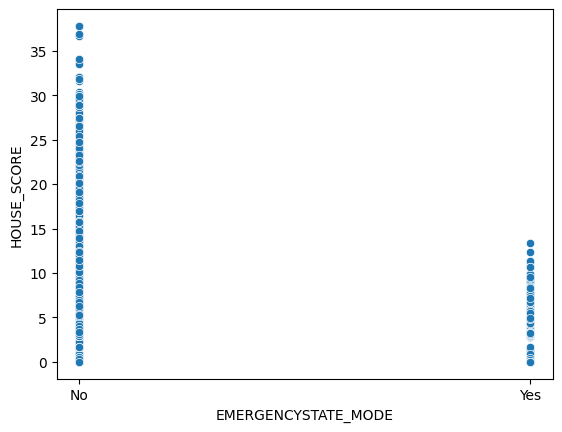

Yes Stats: 
 count    2328.000000
mean        4.076234
std         1.546198
min         0.000000
25%         3.071275
50%         3.353300
75%         5.292375
max        13.389000
Name: HOUSE_SCORE, dtype: float64

No stats: 
 count    159428.000000
mean          7.482037
std           3.340686
min           0.000000
25%           5.147100
50%           7.429900
75%           9.092225
max          37.790400
Name: HOUSE_SCORE, dtype: float64

 Stats of HOUSE_SCORE for Na values of EMERGENCYSTATE_MODE: 
 count    145755.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: HOUSE_SCORE, dtype: float64


In [111]:
# Plot the 'EMERGENCYSTATE_MODE' vs. 'HOUSE_SCORE
sns.scatterplot(train_df, x="EMERGENCYSTATE_MODE", y="HOUSE_SCORE")
plt.show()

# See the stats for each of the values of EMERGENCYSTATE_MODE
print(
    "Yes Stats: \n",
    train_df[(train_df["EMERGENCYSTATE_MODE"] == "Yes")]["HOUSE_SCORE"].describe(),
)

print(
    "\nNo stats: \n",
    train_df[(train_df["EMERGENCYSTATE_MODE"] == "No")]["HOUSE_SCORE"].describe(),
)

# See the values of HOUSE_SCORE for the NA values of EMERGENCYSTATE_MODE
print(
    "\n",
    "Stats of HOUSE_SCORE for Na values of EMERGENCYSTATE_MODE: \n",
    train_df[(train_df["EMERGENCYSTATE_MODE"].isna())]["HOUSE_SCORE"].describe(),
)

There we can see that all of the values derived from `HOUSE_SCORE` for NA values of `EMERGENCYSTATE_MODE` are 0, which means that the other values related to the house were unknown too. Since the number of NA values are high in this column we can't just remove them, we could use the probablity distribution of "Yes" and "No" to populate and fill in the values of `EMERGENCYSTATE_MODE`

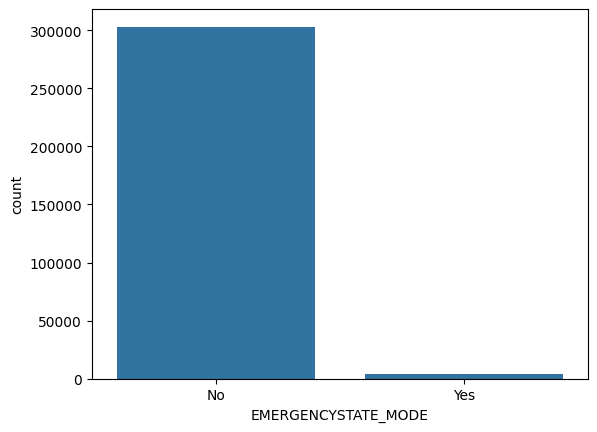

The number of final NA values in 'EMERGENCYSTATE_MODE' Column:  0


In [112]:
# FInd the counts of Yes and No in column
emergency_values = train_df["EMERGENCYSTATE_MODE"].value_counts()

# Calculate the probability
no_prob = emergency_values["No"] / emergency_values.sum()

# Generate Series of random data based on the calculated probability of Yes and No
random_values = np.random.choice(
    ["Yes", "No"], size=len(train_df), p=[1 - no_prob, no_prob]
)
train_df["EMERGENCYSTATE_MODE"] = train_df["EMERGENCYSTATE_MODE"].fillna(
    pd.Series(random_values)
)

sns.barplot(train_df["EMERGENCYSTATE_MODE"].value_counts())
plt.show()

print(
    "The number of final NA values in 'EMERGENCYSTATE_MODE' Column: ",
    train_df["EMERGENCYSTATE_MODE"].isna().sum(),
)

In [113]:
print(
    "Number of NA values in 'NAME_CONTRACT_TYPE' column: ",
    train_df["NAME_CONTRACT_TYPE"].isna().sum(),
)
print(
    "Number of NA values in 'CODE_GENDER' column: ",
    train_df["CODE_GENDER"].isna().sum(),
)

factor_cols = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "EMERGENCYSTATE_MODE",
]
factor_objects = {}

for col_name in factor_cols:
    factor_objects[col_name] = {"unique_value": None, "categories": None}
    train_df, unique_vals, category_vals = factorize_col(train_df, col_name=col_name)
    factor_objects[col_name]["unique_value"] = unique_vals
    factor_objects[col_name]["categories"] = category_vals

Number of NA values in 'NAME_CONTRACT_TYPE' column:  0
Number of NA values in 'CODE_GENDER' column:  0


In order to replace the Categorical variables (especially the Nominal variables) that have many different values, we can keep the high repeating values and replace the low repeatable values with "Other" category name.

- `OCCUPATION_TYPE`: What kind of occupation does the client have
- `ORGANIZATION_TYPE`: Type of organization where client works

In [ ]:
train_df = train_df.pipe(micro.clean_organization_col)
test_df = test_df.pipe(micro.clean_oraganization_col)

In [53]:
def replace_nominal_category(
    train_data: pd.DataFrame, test_data: pd.DataFrame, col_names: list
) -> pd.DataFrame:
    """Replace the Nominal values with less than 1% with 'Other' value."""
    for col_name in col_names:
        column_counts = train_data[col_name].value_counts(normalize=True)
        replace_list = column_counts[(column_counts <= 0.01)].index.to_list()

        train_data[col_name] = train_data[col_name].replace(replace_list, "Other")
        test_data[col_name] = test_data[col_name].replace(replace_list, "Other")

        train_df[col_name] = train_df[col_name].fillna("missing")
        test_df[col_name] = test_df[col_name].fillna("missing")
    return train_data, test_data


train_df, test_df = replace_nominal_category(
    train_df, test_df, col_names=["ORGANIZATION_TYPE", "OCCUPATION_TYPE"]
)

We try and encode the categorical variables with on hot encoding:

- `HOUSETYPE_MODE`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
- `NAME_TYPE_SUITE`: Who was accompanying client when he was applying for the loan
- `NAME_INCOME_TYPE`: Clients income type (businessman, working, maternity leave)
- `NAME_EDUCATION_TYPE`: Level of highest education the client achieved
- `NAME_FAMILY_STATUS`: Family status of the client
- `NAME_HOUSING_TYPE`: What is the housing situation of the client (renting, living with parents, ...)
- `FONDKAPREMONT_MODE`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

At last we keep the one hot encoder objects to apply them to the test dataset

In [114]:
categorical_cols = [
    "WALLSMATERIAL_MODE",
    "HOUSETYPE_MODE",
    "FONDKAPREMONT_MODE",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
]
train_df["ORGANIZATION_TYPE"].value_counts()
# Wallsmaterial -> Others
# HOUSETYPE_MODE -> missing
# FONDKAPREMONT_MODE -> not specified
#

ORGANIZATION_TYPE
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

['Business Entity',
 'XNA',
 'Self-employed',
 'Other',
 'Trade',
 'Industry',
 'Medicine',
 'Government',
 'Transport',
 'School',
 'Kindergarten',
 'Construction',
 'Security',
 'Housing',
 'Military',
 'Bank',
 'Agriculture',
 'Police',
 'Postal',
 'Security Ministries',
 'Restaurant',
 'Services',
 'University',
 'Hotel',
 'Electricity',
 'Insurance',
 'Telecom',
 'Emergency',
 'Advertising',
 'Realtor',
 'Culture',
 'Mobile',
 'Legal Services',
 'Cleaning',
 'Religion']

In [43]:
train_df[(train_df["HOUSETYPE_MODE"] == "reg oper account")][
    "WALLSMATERIAL_MODE"
].value_counts(normalize=True)

WALLSMATERIAL_MODE
Panel           0.444446
Stone, brick    0.424420
Block           0.061724
Wooden          0.033444
Mixed           0.013569
Monolithic      0.012032
Others          0.010365
Name: proportion, dtype: float64

In [34]:
categorical_cols = [
    "WALLSMATERIAL_MODE",
    "HOUSETYPE_MODE",
    "FONDKAPREMONT_MODE",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
]
oneh_objects = {}
for col_name in categorical_cols:
    train_df, oneh_objects[col_name] = onehot_conv(train_df, col_name=col_name)
    train_df = train_df.drop(columns=[col_name])

print(oneh_objects)

{'WALLSMATERIAL_MODE': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'HOUSETYPE_MODE': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'FONDKAPREMONT_MODE': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'NAME_TYPE_SUITE': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'NAME_INCOME_TYPE': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'NAME_EDUCATION_TYPE': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'NAME_FAMILY_STATUS': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'NAME_HOUSING_TYPE': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'OCCUPATION_TYPE': OneHotEncoder(handle_unknown='infrequent_if_exist'), 'ORGANIZATION_TYPE': OneHotEncoder(handle_unknown='infrequent_if_exist')}


house related columns which have numeric values can be summarized. We can use PCA in order to summarize the cols. we try to capture the PCA items that can explain 95% of the variance of the data.

In [35]:
# Define house columns
house_cols = [
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "TOTALAREA_MODE",
    "EMERGENCYSTATE_MODE",
]

We take multiple steps:
1. Use iterative Imputer to handle the missing values.
2. Use standard scaler to scale the columns
3. Fit PCA
4. Apply Cumulative sum to find how many PCAs can explain 95% variance of data.
5. Select the final PCA values.

This step Might take some time

In [36]:
avg_imputer = IterativeImputer(max_iter=20)
imput_array = avg_imputer.fit_transform(train_df[house_cols].to_numpy())

std_scaler = StandardScaler()
std_avg_cols = std_scaler.fit_transform(imput_array)

pca_avg = PCA()
pca_avg.fit(std_avg_cols)
var_ratio = np.cumsum(pca_avg.explained_variance_ratio_)
pca_components = var_ratio[(var_ratio <= 0.95)].shape[0]

pca_avg = PCA(n_components=pca_components)
pca_col_names = [f"PCA_{i}" for i in range(pca_components)]
train_df[pca_col_names] = pca_avg.fit_transform(std_avg_cols)
train_df = train_df.drop(columns=house_cols)

print("Name of the pca columns are: ", pca_col_names)

ValueError: could not convert string to float: 'Other'

Map the Day column, We could use One hot encoder too.

In [38]:
day_mapping = {
    "MONDAY": 1,
    "TUESDAY": 2,
    "WEDNESDAY": 3,
    "THURSDAY": 4,
    "FRIDAY": 5,
    "SATURDAY": 6,
    "SUNDAY": 7,
}
train_df["WEEKDAY_APPR_PROCESS_START"] = train_df["WEEKDAY_APPR_PROCESS_START"].map(
    day_mapping
)



- REGION_RATING_CLIENT = Our rating of the region where client lives (1,2,3)
- REGION_RATING_CLIENT_W_CITY = Our rating of the region where client lives with taking city into account (1,2,3)

In [40]:
train_df["REGION_RATING_CLIENT"] = train_df[
    ["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"]
].sum(axis=1)
train_df = train_df.drop(columns=["REGION_RATING_CLIENT_W_CITY"])

In [ ]:
vif_df = train_df.select_dtypes("int")
vif_df = pd.concat([vif_df, train_df.select_dtypes("float")], axis=1)
vif_df.info()

In [ ]:
vif_df = train_df.select_dtypes("int")
vif_df = pd.concat([vif_df, train_df.select_dtypes("float")], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [
    variance_inflation_factor(vif_df.values, i) for i in range(len(vif_df.columns))
]

In [ ]:
vif_data.sort_values(by="VIF", ascending=False)

# 4.Model